In [1]:
import skcriteria as skc
from skcriteria import pipeline
from skcriteria.preprocessing import invert_objectives, weighters, scalers
from skcriteria.madm import similarity, moora, electre

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics as skl_metrics
from sklearn.linear_model import LinearRegression

import garpar as gp 
import pandas as pd 
import numpy as np
import itertools as it


In [2]:
skc.VERSION

'0.8.3'

In [3]:
wfci = pd.read_csv("/home/nadia/Dropbox/tesis doctoral 2/datosFCI_sin_cedears.csv")
wfci.columns = wfci.columns.str.strip()
wfci["Fondo"] = [
    "Galicia", 
    "BNA",
    "MACRO",
    "Credicoop",
    "ICBC",
    "Comafi",
    "HSBC",
    "Patagonia",
    "Mariva",
    "Supervielle",
    "Santander",
    "Bs.As.",
    "Val.Allaria",
    "Val.Arpenta",
    "Val.Bull",
    "Val.SBS",
    "Val.Valiant"]
    

In [4]:
wfci.Fondo

0         Galicia
1             BNA
2           MACRO
3       Credicoop
4            ICBC
5          Comafi
6            HSBC
7       Patagonia
8          Mariva
9     Supervielle
10      Santander
11         Bs.As.
12    Val.Allaria
13    Val.Arpenta
14       Val.Bull
15        Val.SBS
16    Val.Valiant
Name: Fondo, dtype: object

se toma un año de la cartera al considerar el horizonte temporar de la inersión. 
Se recomienda tomar un año en optimización de carteras para estimar los retornos.

In [5]:
mervalf = gp.datasets.load_MERVAL(first="29-07-2021", 
                                  last = "29-07-2022")
mervalf

Stocks,ALUA[⚖ 0.019231],BBAR[⚖ 0.019231],BYMA[⚖ 0.019231],CEPU[⚖ 0.019231],COME[⚖ 0.019231],CRES[⚖ 0.019231],CVH[⚖ 0.019231],EDN[⚖ 0.019231],GGAL[⚖ 0.019231],HARG[⚖ 0.019231],...,MOLA[⚖ 0.019231],MOLI[⚖ 0.019231],MORI[⚖ 0.019231],OEST[⚖ 0.019231],PATA[⚖ 0.019231],POLL[⚖ 0.019231],RIGO[⚖ 0.019231],SAMI[⚖ 0.019231],SEMI[⚖ 0.019231],TGLT[⚖ 0.019231]
Days,,,,,,,,,,,,,,,,,,,,,
2021-07-29,60.40,193.25,780.00,45.00,4.40,115.50,345.0,39.85,147.60,178.00,...,934.0,87.30,15.55,39.5,32.4,13.0,149.5,118.75,5.50,3.87
2021-07-30,60.30,188.80,780.00,44.65,4.33,112.25,339.0,39.00,142.55,176.00,...,894.0,85.40,15.45,39.5,32.2,15.0,149.0,117.75,5.45,3.80
2021-08-02,61.50,186.25,785.00,45.85,4.50,114.55,333.5,40.30,142.35,179.50,...,877.0,85.60,15.05,39.3,32.0,14.9,147.0,119.75,5.55,3.90
2021-08-03,61.10,185.00,790.00,44.65,4.50,111.70,332.0,41.00,145.60,179.25,...,957.0,88.00,15.20,39.0,32.0,14.9,147.0,120.00,5.55,3.80
2021-08-04,59.80,183.65,790.00,42.55,4.60,110.35,329.5,39.85,143.55,180.50,...,1030.0,88.70,15.00,36.5,32.1,14.8,147.0,122.00,5.40,3.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,144.75,251.85,204.50,104.10,15.75,164.90,686.0,75.60,214.35,194.50,...,2447.0,156.00,16.75,60.0,57.8,28.5,250.0,141.25,9.00,4.46
2022-07-26,139.50,257.75,205.50,106.30,15.30,174.90,700.5,75.90,214.50,201.00,...,2412.0,155.00,16.80,62.0,57.0,29.0,250.0,137.50,8.94,4.45
2022-07-27,146.50,274.85,222.00,117.55,16.25,183.50,707.5,79.00,225.65,210.00,...,2399.5,158.50,17.55,65.0,59.5,30.0,260.0,142.00,9.28,4.53


In [6]:
def asignw(nfondo):
    fondo = wfci[wfci["Fondo"]== nfondo]
    weights = []
    for stock in mervalf.stocks:
        try:
            w = float(fondo[stock].values[0].replace(",","."))
        except KeyError:
            w = 0.
        weights.append(w)

    nm = mervalf.copy(weights=weights,title=nfondo).scale_weights()
    return nm

def get_metrics(nfondo):
    mopt = asignw(nfondo).dprune().wprune().scale_weights()
    metrics = {
        "Fondo": nfondo,
       # "entropy": entropy,
        "Stock_number": len(mopt.stocks),
        "Beta_port": mopt.risk.pf_beta(),
        "variance_port": mopt.risk.pf_var(),
        "VaR_port": np.sum(mopt.risk.value() * mopt.weights),
        "Sharpe_Ratio": mopt.risk.sharpe(),
        "Treynor_Ratio": mopt.risk.treynor_ratio(),
        "Cross_Entropy": mopt.div.cross_entropy(),
        "KeyZang_Entropy": mopt.div.ke_zang_entropy(),
        "Zheng_Entropy": mopt.div.zheng_entropy(),
        #"Delta_diversific": mopt.div.delta(),
        "Div_Ratio": mopt.div.ratio(),
        "CV_MC":(mopt.div.mrc() *  mopt.weights).std() / (mopt.div.mrc() *  mopt.weights).mean(),
        "PDI": mopt.div.pdi(n_components=5, random_state=100),
    }
    return metrics
    

In [7]:
translate = {
        "stocks_seleccionados": "Selected stocks",
       }

## Calculo de métricas

aca hago zaraza del zaraza

$u_9 = 23$

In [8]:
rows = []
for nfondo in wfci.Fondo:
    metrics = get_metrics(nfondo)
    rows.append(metrics)
metrics = pd.DataFrame(rows)
metrics.set_index("Fondo", inplace=True, drop=True)
metrics

,Stock_number,Beta_port,variance_port,VaR_port,Sharpe_Ratio,Treynor_Ratio,Cross_Entropy,KeyZang_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
Fondo,,,,,,,,,,,,
Galicia,27,1.673191,0.106095,0.040332,-3.237707,-0.642242,1.026304,2.754291,2.648196,0.094987,1.352807,1.356961
BNA,19,1.305662,0.107886,0.040073,-2.825605,-0.726144,0.514198,2.696622,2.588735,0.093679,0.963059,1.708972
MACRO,19,1.704964,0.112052,0.040180,-2.813989,-0.564210,0.778968,2.470591,2.358540,0.092209,1.225660,1.689137
Credicoop,18,1.354701,0.102477,0.039187,-2.891776,-0.698101,0.454785,2.710788,2.608311,0.096451,0.810086,1.673447
ICBC,26,1.468175,0.088988,0.038297,-3.360620,-0.696445,0.678679,2.903753,2.814764,0.102112,1.055144,1.381591
Comafi,7,0.976238,0.119388,0.040135,-2.818415,-1.018025,0.192727,1.906383,1.786995,0.081438,0.506193,3.650204
HSBC,24,1.876506,0.104736,0.039604,-3.210461,-0.564347,1.009999,2.677716,2.572979,0.096354,1.240999,1.369945
Patagonia,16,0.920309,0.115454,0.040872,-2.812602,-1.060166,0.386546,2.556743,2.441289,0.089836,0.925144,1.914891
Mariva,15,1.463561,0.111366,0.040206,-2.223565,-0.520673,0.729467,2.316669,2.205304,0.096718,1.041671,1.936375


In [9]:
metrics.describe()

,Stock_number,Beta_port,variance_port,VaR_port,Sharpe_Ratio,Treynor_Ratio,Cross_Entropy,KeyZang_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,16.411765,1.339938,0.110256,0.039950,-2.858527,-0.774210,0.567449,2.459759,2.349503,0.093555,0.959161,1.951765
std,6.103880,0.338658,0.008403,0.000715,0.341308,0.239994,0.378853,0.265680,0.271188,0.005564,0.264844,0.581681
min,7.000000,0.920309,0.088988,0.038297,-3.447793,-1.277967,0.065626,1.906383,1.786995,0.081438,0.506193,1.356961
25%,11.000000,0.988322,0.104736,0.039446,-3.015587,-1.006628,0.295975,2.308201,2.189832,0.091985,0.703042,1.689137
50%,18.000000,1.354701,0.110189,0.040135,-2.825605,-0.698101,0.454785,2.472599,2.358540,0.093679,0.963059,1.768526
75%,19.000000,1.614809,0.117246,0.040332,-2.812602,-0.564347,0.778968,2.677716,2.572979,0.096451,1.225660,2.073541
max,27.000000,1.914415,0.124626,0.040909,-2.223565,-0.400044,1.297474,2.903753,2.814764,0.102112,1.352807,3.650204


In [10]:
metrics.skew(axis = 0, skipna = None, level = None, numeric_only = None)

Stock_number       0.054642
Beta_port          0.255880
variance_port     -0.659074
VaR_port          -0.773354
Sharpe_Ratio       0.207153
Treynor_Ratio     -0.459235
Cross_Entropy      0.511202
KeyZang_Entropy   -0.388892
Zheng_Entropy     -0.343898
Div_Ratio         -0.372444
CV_MC             -0.065652
PDI                1.865355
dtype: float64

In [11]:
metrics.kurt(axis=0, skipna=True, level=None, numeric_only=None)

Stock_number      -0.751806
Beta_port         -1.258173
variance_port      1.314480
VaR_port           0.244370
Sharpe_Ratio       0.011920
Treynor_Ratio     -0.578919
Cross_Entropy     -0.821514
KeyZang_Entropy   -0.372987
Zheng_Entropy     -0.359338
Div_Ratio          0.197386
CV_MC             -1.124959
PDI                3.972555
dtype: float64

<AxesSubplot:>

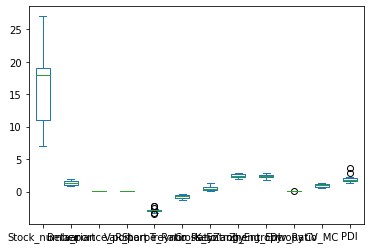

In [12]:
metrics.plot.box()

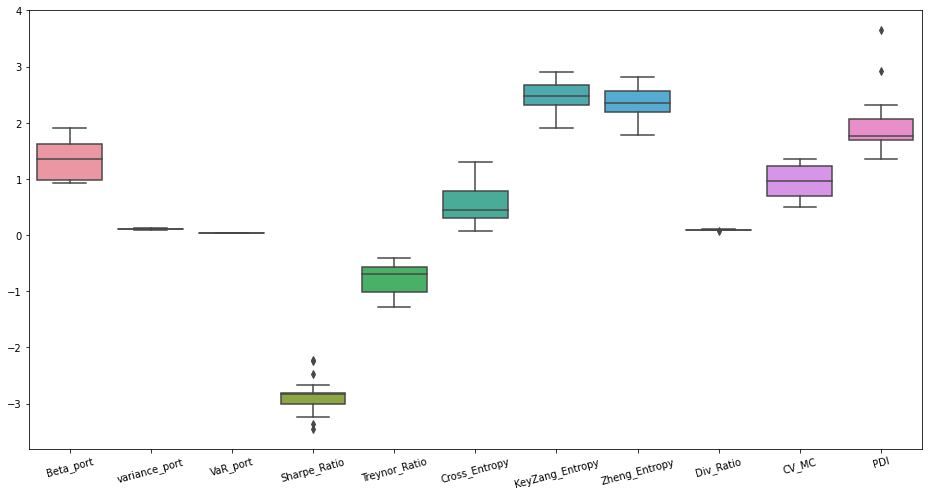

In [13]:

fig, ax = plt.subplots(figsize=(13,7))
#metrics.plot.box(ax=ax, color="g")
sns.boxplot(data=metrics[metrics.columns[1:]], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 15)
fig.tight_layout()
plt.savefig("cajasinnormalizar.pdf")
# excluye el criterio del conteo porque sino las cajas quedan un moco

<AxesSubplot:xlabel='Fondo'>

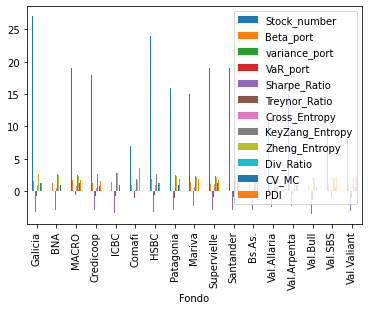

In [14]:
metrics.plot.bar()
#fig, ax = plt.subplots(figsize=(13,7))
#metrics.plot("heatmap", ax=ax, cbar=False, cmap="Greys")
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 15)
#fig.tight_layout()

In [15]:
objectives = [
    max, #     'stocks_seleccionados', coincide con definición mayor número de stocks
    min, #     'beta_portafolio', ver estaría bueno fuera cercana a 1 a màs o menos pronbunciada que el mercado. Ver RIM 
    min, #     'varianza_portafolio',
    min, #     'VaR_portafolio', es el valor promedio ponderado que asigna una probabilidad del 5% a tener pérdida, se busca lo más bajo posible para que pequeños movimientos no afecten  
    max, #     'Sharpe_Ratio', es el exceso de rendimiento sobre la tasa libre de riesgo en relación a la variabilidad, busco maximizar porque denominador debe hacerse más pequeño y numerador más grande 
    max, #     'Treynor_Ratio', mide el rendimiento en relación al Beta_i
    min, #     'Entropia_cruzada', mide el desorden al compararlo con una estrategia teórica de riski part equall
    min, #     'Entropia_KeyZang', considera una medida de eentropía y variabilidad
    min, #     'Entropia_Zheng', 
    max, #     'Ratio_diversific', mide la diversificación ganada por  mantener activos no correlacionados
    min, #     'CV_Contribuciones_marginales', si todos los activos tienen igual contribución marginal es un portfolio diversificado
    max, #     'Indice_diversific_port, si hay correlacióan alta el índice dará un valor bajo mientras que si no hay correlación el índice tenderá al valor N
]

dm = skc.mkdm(metrics.to_numpy(), objectives, alternatives=metrics.index, criteria=metrics.columns)

In [16]:
pipe = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    #scalers.SumScaler(target="weights"),
    scalers.SumScaler(target="matrix"),
    weighters.Critic(),
    similarity.TOPSIS(),
)
pipe

/tmp/ipykernel_31147/2046903838.py:5: SKCriteriaDeprecationWarning: Call to deprecated class Critic. (Use ``skcriteria.preprocessing.weighters.CRITIC`` instead) -- Deprecated since version 0.8.
  weighters.Critic(),


<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('sumscaler', <SumScaler [target='matrix']>), ('critic', <Critic [correlation='pearson', scale=True]>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [17]:
result = pipe.evaluate(dm)
result

Alternatives,Galicia,BNA,MACRO,Credicoop,ICBC,Comafi,HSBC,Patagonia,Mariva,Supervielle,Santander,Bs.As.,Val.Allaria,Val.Arpenta,Val.Bull,Val.SBS,Val.Valiant
Rank,3,11,5,13,6,7,4,10,8,2,1,12,17,14,9,15,16


In [18]:
result.e_.similarity

array([0.55205637, 0.3835364 , 0.46874065, 0.34773412, 0.46136856,
       0.41868557, 0.53281144, 0.39146407, 0.41228412, 0.5649925 ,
       0.59934309, 0.35901587, 0.27918637, 0.33833622, 0.41158385,
       0.30929568, 0.30898684])

In [19]:
dmt = pipe.transform(dm)


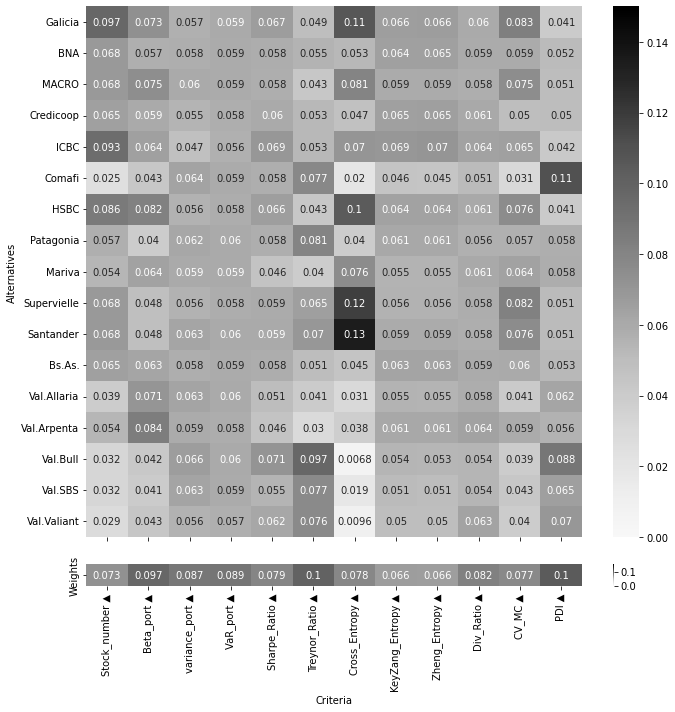

In [20]:
fig, axs = plt.subplots(
    2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [5, .2]})
dmt.plot.heatmap(ax=axs[0], cmap="Greys", vmin=0, vmax=.15, center=0.07)
dmt.plot.wheatmap(ax=axs[1], cmap="Greys", vmin=0, vmax=.15, center=0.07)

axs[0].set_xticklabels([])
axs[0].set_xlabel("")
fig.tight_layout();

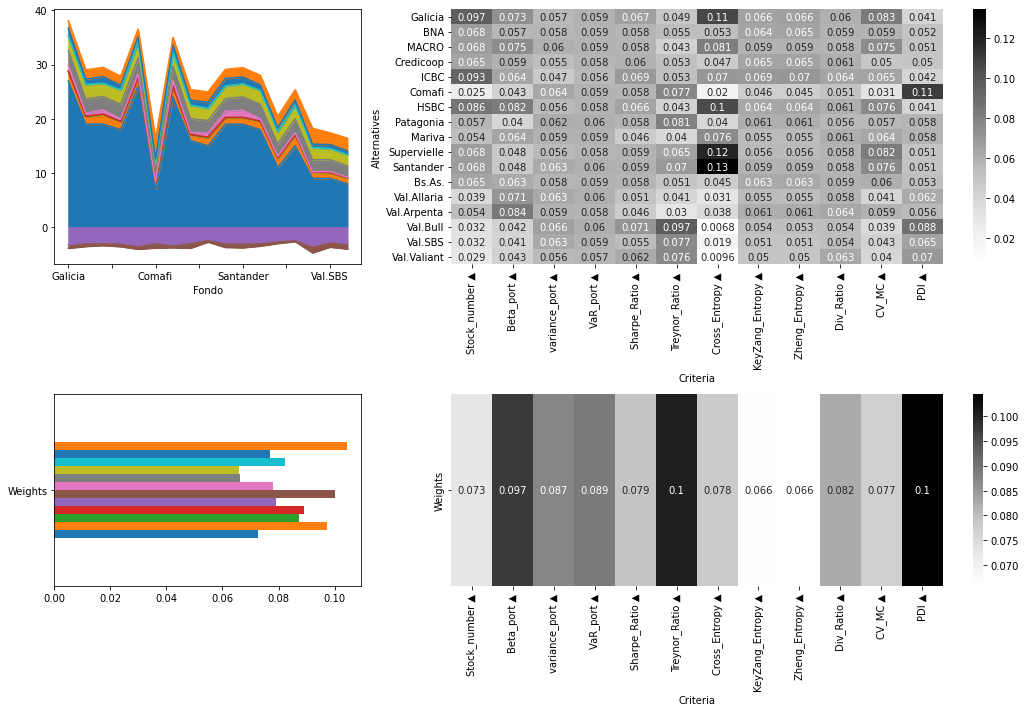

In [21]:
fig, axs = plt.subplots(
    2, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [2, 4], 'height_ratios': [4, 3]})
metrics.plot.area(ax=axs[0,0], legend=False); dmt.plot.heatmap(ax=axs[0, 1], cmap="Greys")
dmt.plot.wbarh(ax=axs[1,0], legend=False); dmt.plot.wheatmap(ax=axs[1, 1], cmap="Greys")
fig.tight_layout();



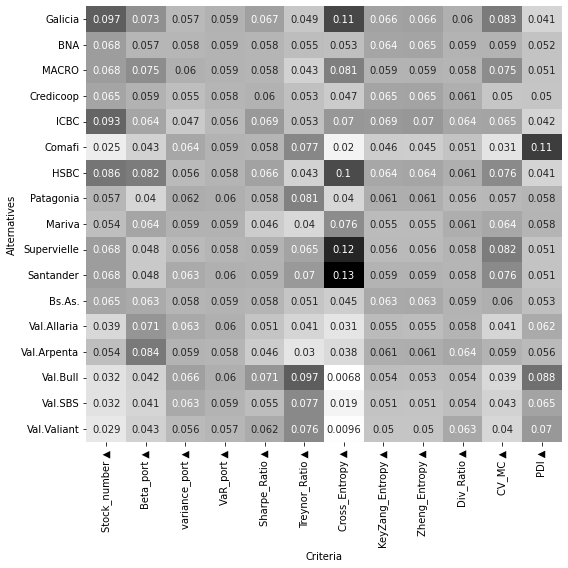

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
dmt.plot(ax=ax, cbar=False, cmap="Greys")
fig.tight_layout()
plt.savefig("Mapadecalo.pdf")

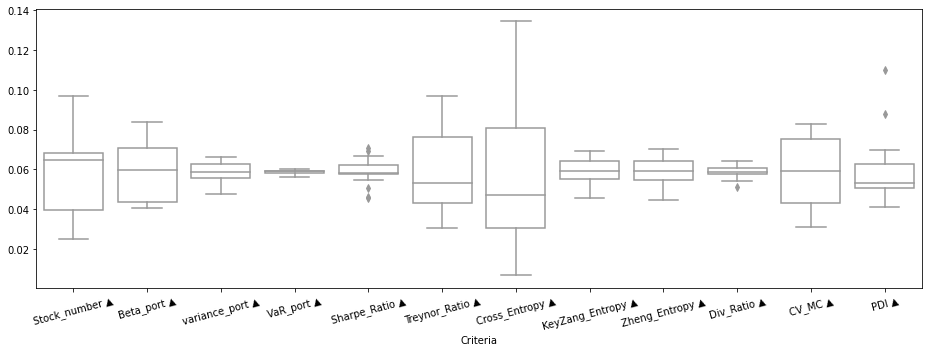

In [23]:
fig, ax = plt.subplots(figsize=(13,5))
dmt.plot.box(ax=ax, color="w")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 15)
fig.tight_layout()
plt.savefig("caja.pdf")

<AxesSubplot:>

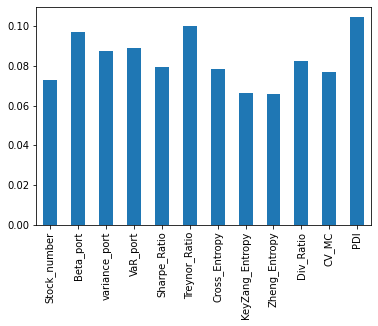

In [24]:
dmt.weights.plot.bar()

<AxesSubplot:ylabel='Frequency'>

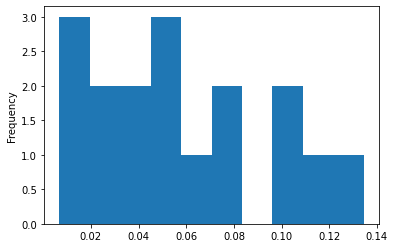

In [25]:
dmt.criteria["Cross_Entropy"].plot.hist()

<AxesSubplot:ylabel='Proportion'>

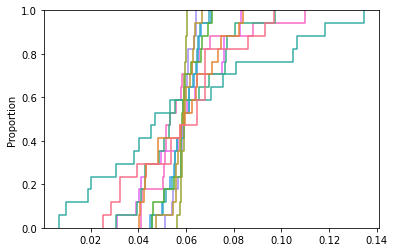

In [26]:
dmt.plot.ogive(legend=False)

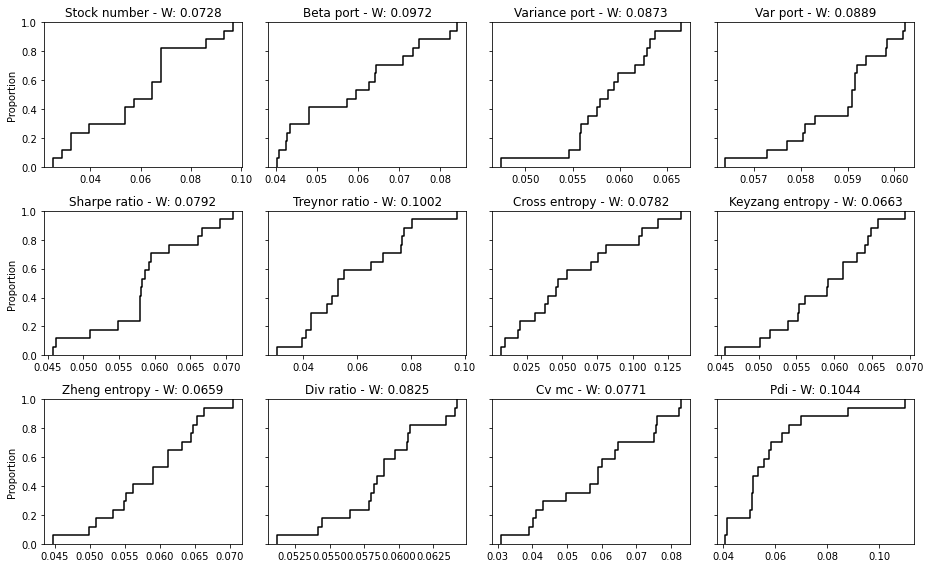

In [27]:
fig, axs = plt.subplots(3,4, sharex=False, sharey=True)
fig.set_size_inches(13,8)
axs = it.chain(*axs)
for crit, wt, ax  in zip(dmt.criteria, dmt.weights, axs):
    valc = dmt.criteria[crit]
    
    sns.ecdfplot(valc, ax=ax, color="k")
    
    ax.set_xlabel("")
    
    title = translate.get(crit, crit)
    title = title.replace("_", " ").capitalize()
    ax.set_title(f"{title} - W: {wt:.4f}")

fig.tight_layout()
plt.savefig("ogive.pdf")

In [28]:
title.capitalize()

'Pdi'

<AxesSubplot:ylabel='Density'>

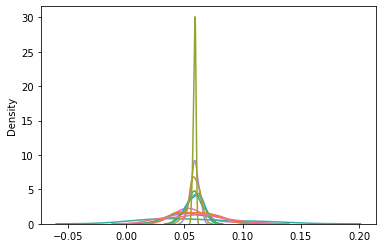

In [29]:
dmt.plot.kde(legend=False)

In [30]:
pipe2 = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    #scalers.SumScaler(target="weights"),
    scalers.SumScaler(target="matrix"),
    weighters.EntropyWeighter(),
    similarity.TOPSIS(),
)
pipe2

<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('sumscaler', <SumScaler [target='matrix']>), ('entropyweighter', <EntropyWeighter []>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [31]:
result2 = pipe2.evaluate(dm)
result2

Alternatives,Galicia,BNA,MACRO,Credicoop,ICBC,Comafi,HSBC,Patagonia,Mariva,Supervielle,Santander,Bs.As.,Val.Allaria,Val.Arpenta,Val.Bull,Val.SBS,Val.Valiant
Rank,3,8,5,9,7,14,4,11,6,2,1,10,13,12,16,15,17


In [32]:
result2.e_.similarity

array([0.76199073, 0.37125957, 0.57259407, 0.32338848, 0.50561555,
       0.14620847, 0.74642218, 0.27596072, 0.52843049, 0.83241277,
       0.89377307, 0.31126   , 0.19052119, 0.25274435, 0.10987473,
       0.11903467, 0.08056739])

In [33]:
dmt2 = pipe2.transform(dm)

<AxesSubplot:>

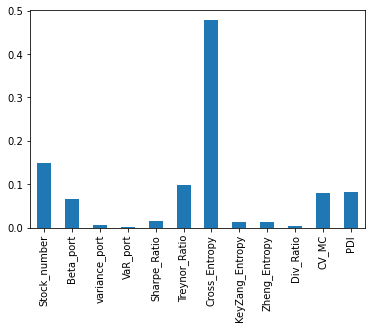

In [34]:
dmt2.weights.plot.bar()

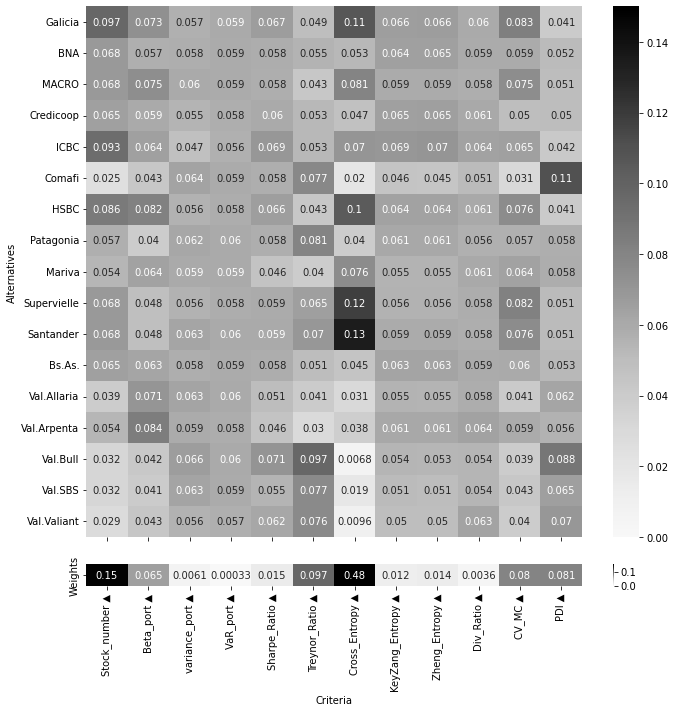

In [35]:
fig, axs = plt.subplots(
    2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [5, .2]})
dmt2.plot.heatmap(ax=axs[0], cmap="Greys", vmin=0, vmax=.15, center=0.07)
dmt2.plot.wheatmap(ax=axs[1], cmap="Greys", vmin=0, vmax=.15, center=0.07)

axs[0].set_xticklabels([])
axs[0].set_xlabel("")
fig.tight_layout();

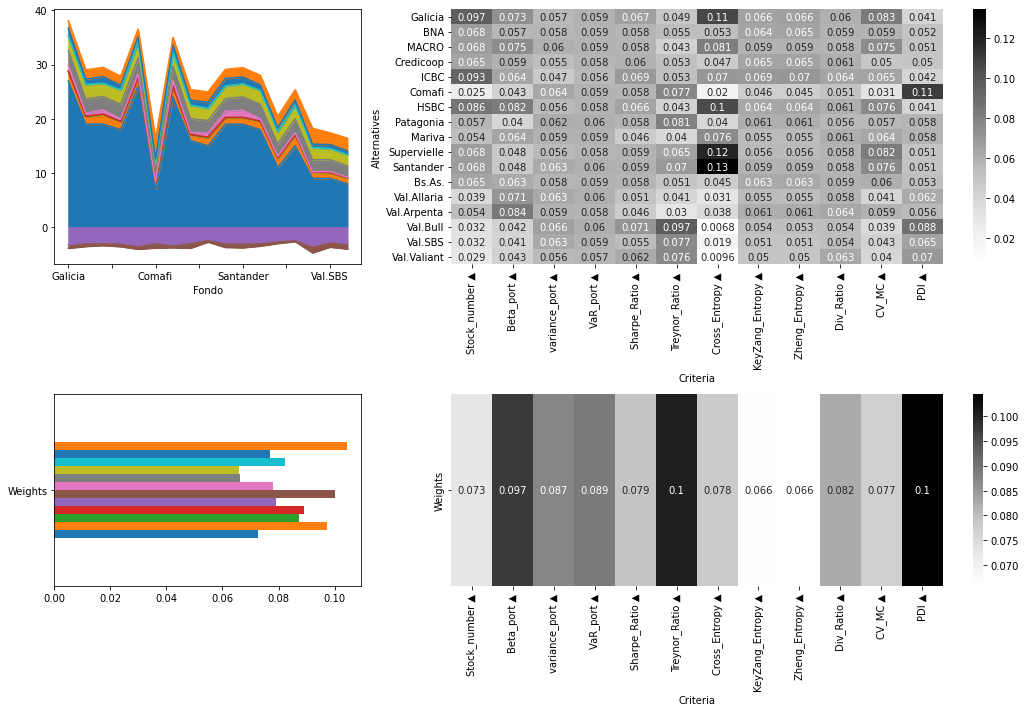

In [36]:
fig, axs = plt.subplots(
    2, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [2, 4], 'height_ratios': [4, 3]})
metrics.plot.area(ax=axs[0,0], legend=False); dmt.plot.heatmap(ax=axs[0, 1], cmap="Greys")
dmt.plot.wbarh(ax=axs[1,0], legend=False); dmt.plot.wheatmap(ax=axs[1, 1], cmap="Greys")
fig.tight_layout();

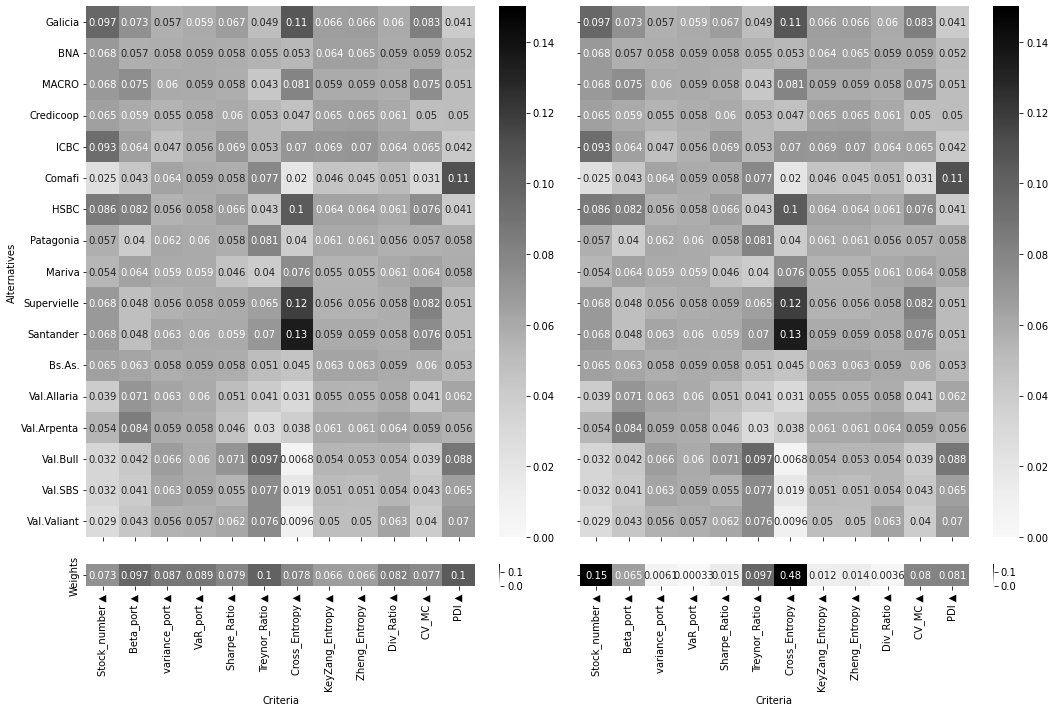

In [37]:
fig, axs = plt.subplots(
    2, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [5, 5],'height_ratios': [5, .2]},sharex=True)
dmt.plot.heatmap(ax=axs[0][0], cmap="Greys", vmin=0, vmax=.15, center=0.07)
dmt2.plot.heatmap(ax=axs[0][1], cmap="Greys", vmin=0, vmax=.15, center=0.07)

dmt.plot.wheatmap(ax=axs[1][0], cmap="Greys", vmin=0, vmax=.15, center=0.07)
dmt2.plot.wheatmap(ax=axs[1][1], cmap="Greys", vmin=0, vmax=.15, center=0.07)


axs[1][1].set_yticklabels([])
axs[0][1].set_yticklabels([])
axs[0][0].set_xlabel("")
axs[0][1].set_xlabel("")
axs[0][1].set_ylabel("")

fig.tight_layout();

In [38]:
pipe3 = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    #scalers.SumScaler(target="weights"),
    scalers.MinMaxScaler(target="matrix"),
    weighters.EntropyWeighter(),
    similarity.TOPSIS(),
)
pipe3

<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('minmaxscaler', <MinMaxScaler [clip=False, criteria_range=(0.0, 1.0), target='matrix']>), ('entropyweighter', <EntropyWeighter []>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [39]:
dmt3 = pipe3.transform(dm)

In [40]:
pipe4 = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    #scalers.SumScaler(target="weights"),
    scalers.MinMaxScaler(target="matrix"),
    weighters.Critic(),
    similarity.TOPSIS(),
)
pipe4

/tmp/ipykernel_31147/990931835.py:5: SKCriteriaDeprecationWarning: Call to deprecated class Critic. (Use ``skcriteria.preprocessing.weighters.CRITIC`` instead) -- Deprecated since version 0.8.
  weighters.Critic(),


<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('minmaxscaler', <MinMaxScaler [clip=False, criteria_range=(0.0, 1.0), target='matrix']>), ('critic', <Critic [correlation='pearson', scale=True]>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [41]:
dmt4 = pipe4.transform(dm)

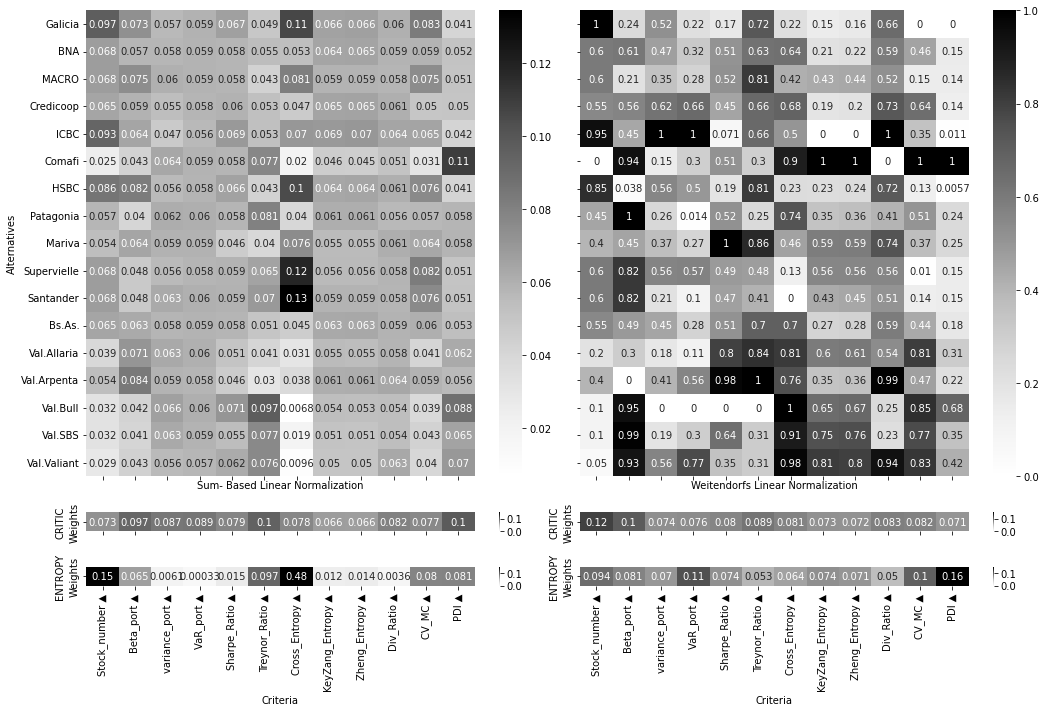

In [42]:
fig, axs = plt.subplots(
    3, 2, figsize=(15,10), gridspec_kw={'width_ratios': [5, 5],'height_ratios': [5, .2, .2]},sharex=True)
dmt.plot.heatmap(ax=axs[0][0], cmap="Greys", )
dmt3.plot.heatmap(ax=axs[0][1], cmap="Greys", )

dmt.plot.wheatmap(ax=axs[1][0], cmap="Greys", vmin=0, vmax=.15, center=0.07)
dmt4.plot.wheatmap(ax=axs[1][1], cmap="Greys", vmin=0, vmax=.15, center=0.07)

dmt2.plot.wheatmap(ax=axs[2][0], cmap="Greys", vmin=0, vmax=.15, center=0.07)
dmt3.plot.wheatmap(ax=axs[2][1], cmap="Greys", vmin=0, vmax=.15, center=0.07)

axs[0][1].set_yticklabels([])
axs[0][0].set_xlabel("Sum- Based Linear Normalization")
axs[0][1].set_xlabel("Weitendorfs Linear Normalization")
axs[0][1].set_ylabel("")
axs[1][0].set_xlabel("")
axs[1][1].set_xlabel("")
axs[1][0].set_ylabel("CRITIC")
axs[2][0].set_ylabel("ENTROPY")
axs[1][1].set_ylabel("CRITIC")
axs[2][1].set_ylabel("ENTROPY")

fig.tight_layout();

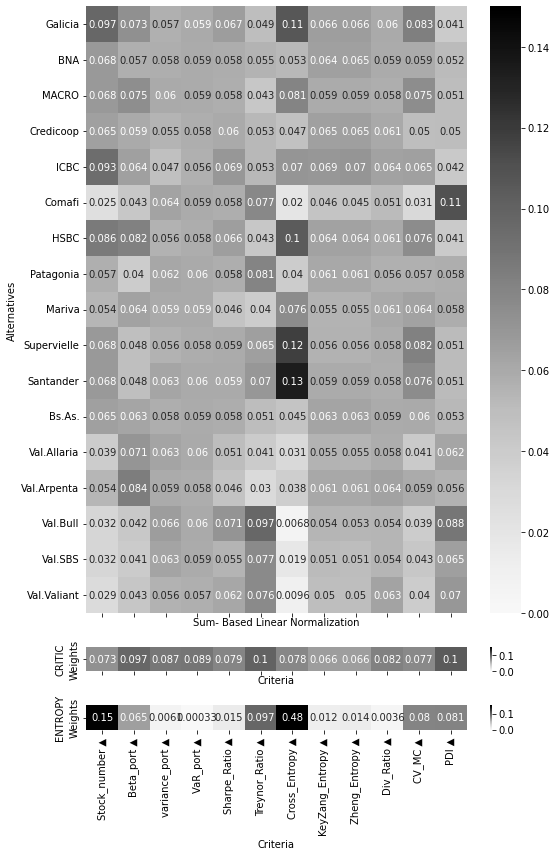

In [43]:
fig, axs = plt.subplots(
    3, 1, figsize=(8,12), gridspec_kw={'height_ratios': [5, .2, .2]},sharex=True)

dmt.plot.heatmap(ax=axs[0], cmap="Greys", vmin=0, vmax=.15, center=0.07 )
dmt.plot.wheatmap(ax=axs[1], cmap="Greys", vmin=0, vmax=.15, center=0.07)
dmt2.plot.wheatmap(ax=axs[2], cmap="Greys", vmin=0, vmax=.15, center=0.07)

axs[0].set_xlabel("Sum- Based Linear Normalization")
axs[1].set_ylabel("CRITIC")
axs[2].set_ylabel("ENTROPY")


fig.tight_layout();
plt.savefig("mapanormal.pdf")


<AxesSubplot:>

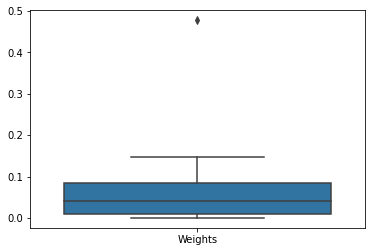

In [44]:
dmt2.plot.wbox()

<AxesSubplot:ylabel='Density'>

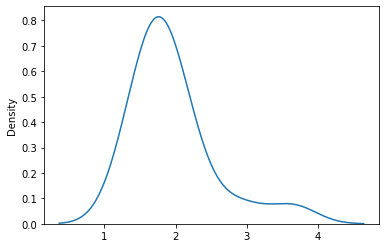

In [45]:
sns.kdeplot(data=dm.matrix[["PDI"]], color="r", legend=False)

In [46]:
import itertools as it

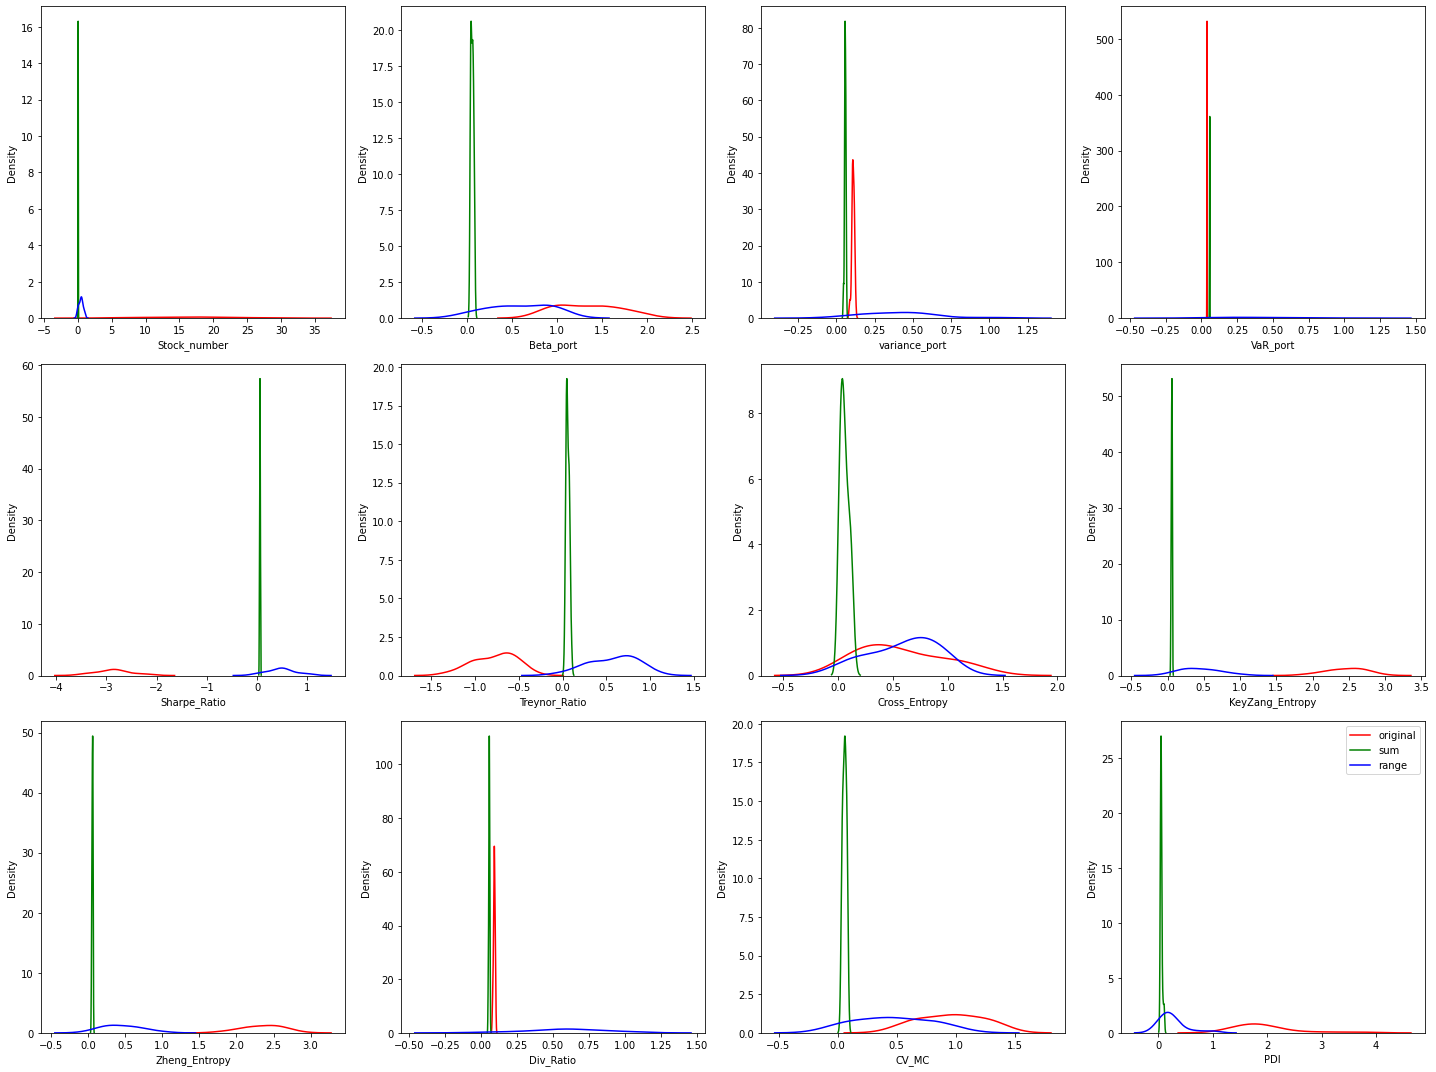

In [47]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for ax, crit in zip(it.chain(*axs), dm.criteria):
    sns.kdeplot(data=dm.matrix[crit], color="r", legend=False, ax=ax, common_norm=True)
    sns.kdeplot(data=dmt.matrix[crit], color="g", legend=False, ax=ax, common_norm=True)
    sns.kdeplot(data=dmt3.matrix[crit], color="b", legend=False, ax=ax, common_norm=True)
    if crit == dm.criteria[-1]:
        ax.legend(["original","sum","range"])
    
fig.tight_layout()

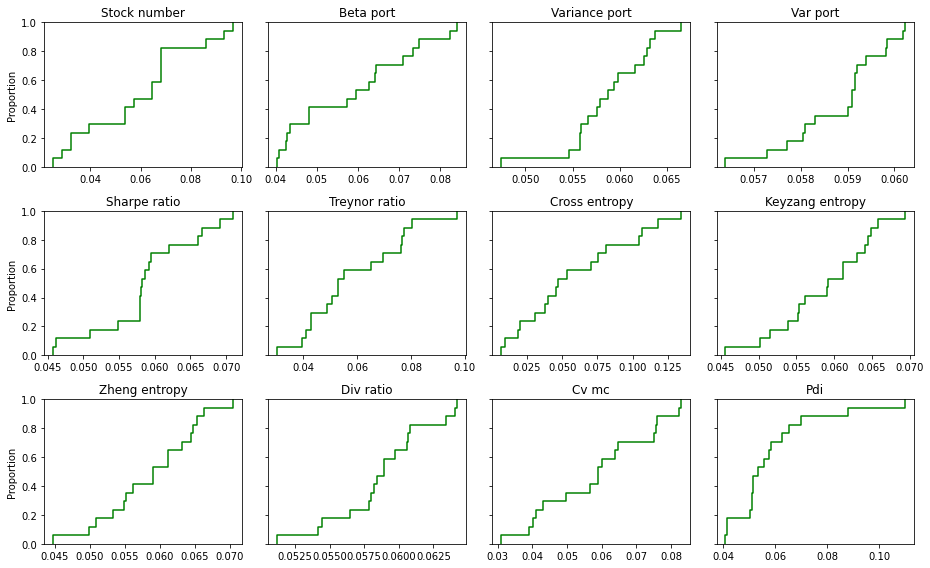

In [48]:
fig, axs = plt.subplots(3,4, sharex=False, sharey=True)
fig.set_size_inches(13,8)
axs = it.chain(*axs)
for crit, wt, ax  in zip(dmt.criteria, dmt.weights, axs):
    valo = dm.criteria[crit]
    valc = dmt.criteria[crit]
    val3 = dmt3.criteria[crit]
    
    #valo= (valo-valo.mean())/valo.std()
    #valc= (valc-valc.mean())/valc.std()


    
    #sns.ecdfplot(valo, ax=ax, color="r")
    sns.ecdfplot(valc, ax=ax, color="g")
    #sns.ecdfplot(val3, ax=ax, color="b")

    ax.set_xlabel("")
    
    title = translate.get(crit, crit)
    title = title.replace("_", " ").capitalize()
    ax.set_title(f"{title}" 
    #- W: {wt:.4f}"
       )        

fig.tight_layout()
plt.savefig("ogive0yN.pdf")


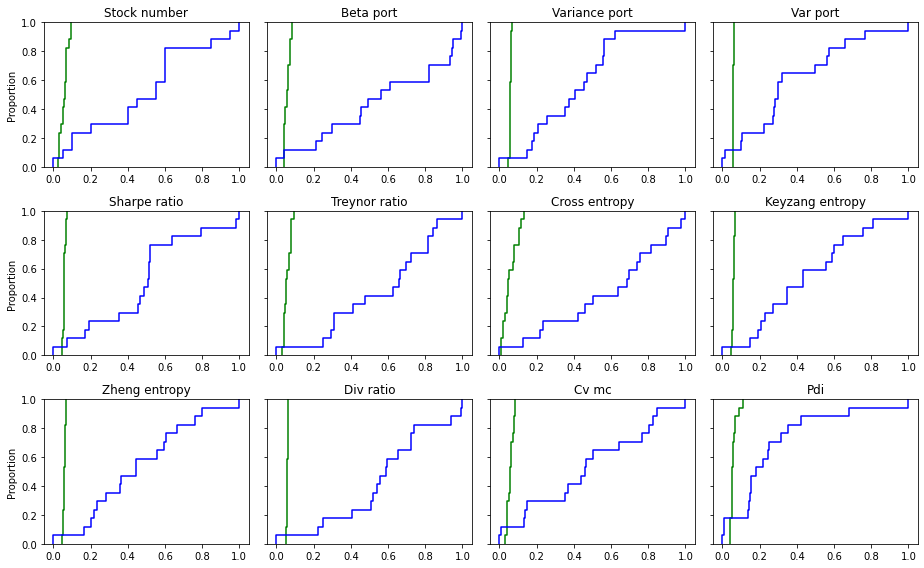

In [49]:
fig, axs = plt.subplots(3,4, sharex=False, sharey=True)
fig.set_size_inches(13,8)
axs = it.chain(*axs)

for crit, wt, ax  in zip(dmt.criteria, dmt.weights, axs):
    valc = dmt.criteria[crit]
    val3 = dmt3.criteria[crit]

    
    sns.ecdfplot(valc, ax=ax, color="g")
    sns.ecdfplot(val3, ax=ax, color="b")

    ax.set_xlabel("")
    
    title = translate.get(crit, crit)
    title = title.replace("_", " ").capitalize()
    ax.set_title(f"{title}" 
    #- W: {wt:.4f}"
       )        

fig.tight_layout()

In [50]:
dmt[['Beta_port', 'variance_port', 'VaR_port', 'PDI']].criteria

_ACArray(['Beta_port', 'variance_port', 'VaR_port', 'PDI'], dtype=object)

In [51]:
print("hola\\nmundo")

hola\nmundo


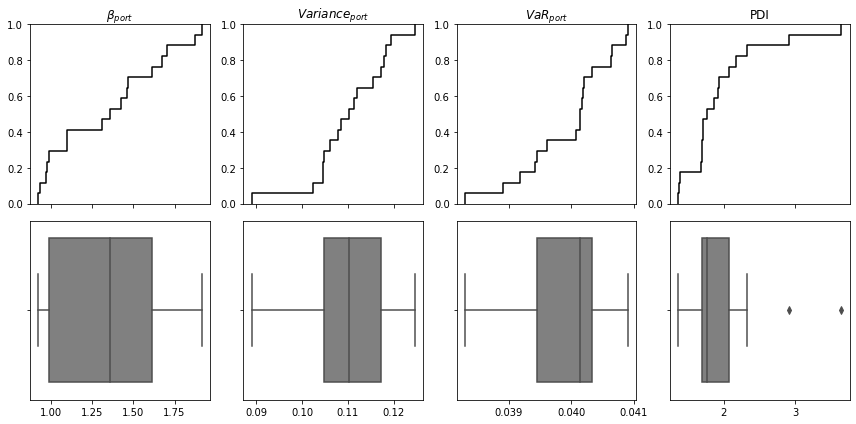

In [52]:
trans = {
    'Beta_port': r"$\beta_{port}$", 
    'variance_port': "$Variance_{port}$", 
    'VaR_port': "$VaR_{port}$", 
    'PDI': "PDI",
}

masym = dmt[list(trans)]

fig, axs = plt.subplots(2, len(trans), sharex=False, sharey=False)
fig.set_size_inches(3 * len(trans), 6)

for crit, ax  in zip(masym.criteria, axs.T):
    
    valo = dm.criteria[crit]
    valc = dmt.criteria[crit]
    val3 = dmt3.criteria[crit]

   # valo =valo/valo.sum()
    
    sns.ecdfplot(x=valo, ax=ax[0], color="k")
    sns.boxplot(x=valo, ax=ax[1], color="grey")
    #sns.ecdfplot(valc, ax=ax, color="g")
    #sns.ecdfplot(val3, ax=ax, color="b")

    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    ax[0].set_xticklabels([])
    
    title = trans[crit]
    ax[0].set_title(title)
    
    ax[1].set_xlabel("")
    
    # comparimos los ejes
    ax[0].get_shared_x_axes().join(*ax)
    
fig.tight_layout()
plt.savefig("ogivesinnormalizar.pdf", bbox_inches='tight')

In [53]:
metrics

,Stock_number,Beta_port,variance_port,VaR_port,Sharpe_Ratio,Treynor_Ratio,Cross_Entropy,KeyZang_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
Fondo,,,,,,,,,,,,
Galicia,27,1.673191,0.106095,0.040332,-3.237707,-0.642242,1.026304,2.754291,2.648196,0.094987,1.352807,1.356961
BNA,19,1.305662,0.107886,0.040073,-2.825605,-0.726144,0.514198,2.696622,2.588735,0.093679,0.963059,1.708972
MACRO,19,1.704964,0.112052,0.040180,-2.813989,-0.564210,0.778968,2.470591,2.358540,0.092209,1.225660,1.689137
Credicoop,18,1.354701,0.102477,0.039187,-2.891776,-0.698101,0.454785,2.710788,2.608311,0.096451,0.810086,1.673447
ICBC,26,1.468175,0.088988,0.038297,-3.360620,-0.696445,0.678679,2.903753,2.814764,0.102112,1.055144,1.381591
Comafi,7,0.976238,0.119388,0.040135,-2.818415,-1.018025,0.192727,1.906383,1.786995,0.081438,0.506193,3.650204
HSBC,24,1.876506,0.104736,0.039604,-3.210461,-0.564347,1.009999,2.677716,2.572979,0.096354,1.240999,1.369945
Patagonia,16,0.920309,0.115454,0.040872,-2.812602,-1.060166,0.386546,2.556743,2.441289,0.089836,0.925144,1.914891
Mariva,15,1.463561,0.111366,0.040206,-2.223565,-0.520673,0.729467,2.316669,2.205304,0.096718,1.041671,1.936375


In [54]:
max_rank = metrics.rank(method="max")
min_rank = metrics.rank(method="min")


In [55]:
rank_arr = np.where(np.array(objectives) ==  max, max_rank, min_rank).astype(int)
rank_df = pd.DataFrame(rank_arr, columns=metrics.columns, index=metrics.index)
rank_df["CRITIC"] = result.to_series()
rank_df["Entropy"] = result2.to_series()

rank_df

,Stock_number,Beta_port,variance_port,VaR_port,Sharpe_Ratio,Treynor_Ratio,Cross_Entropy,KeyZang_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI,CRITIC,Entropy
Fondo,,,,,,,,,,,,,,
Galicia,17,14,6,13,3,12,15,16,16,11,17,1,3,3
BNA,14,8,7,7,9,8,10,14,14,9,9,8,11,8
MACRO,14,15,11,11,12,14,13,8,9,6,13,5,5,5
Credicoop,10,9,2,3,6,9,9,15,15,13,6,4,13,9
ICBC,16,12,1,1,2,10,11,17,17,17,12,3,6,7
Comafi,1,4,16,9,11,3,4,1,1,1,1,17,7,14
HSBC,15,16,5,6,4,13,14,13,13,12,15,2,4,4
Patagonia,8,1,12,16,13,2,7,11,10,4,7,11,10,11
Mariva,7,11,10,12,17,16,12,6,6,14,11,12,8,6


In [56]:
corr_rank = rank_df.corr()
corr_rank_critic= corr_rank["CRITIC"]
corr_rank_critic

Stock_number      -0.667596
Beta_port         -0.142157
variance_port      0.112745
VaR_port          -0.151961
Sharpe_Ratio       0.394608
Treynor_Ratio      0.022059
Cross_Entropy     -0.794118
KeyZang_Entropy   -0.284314
Zheng_Entropy     -0.264706
Div_Ratio          0.107843
CV_MC             -0.735294
PDI                0.549020
CRITIC             1.000000
Entropy            0.811275
Name: CRITIC, dtype: float64

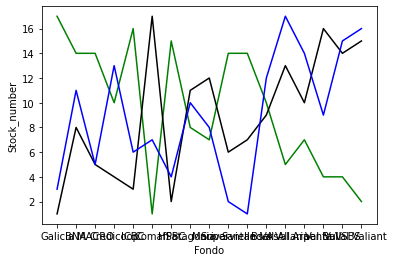

In [57]:
sn = rank_df["Stock_number"]
pdi = rank_df["PDI"]
critic = rank_df["CRITIC"]
entropy =rank_df["Entropy"]
sns.lineplot(data=sn,color="g")
sns.lineplot(data=pdi,color="k")
sns.lineplot(data=critic,color="b")
plt.show()

In [60]:
# fig, axs = plt.subplots(3,4, sharex=True, sharey=True)
# fig.set_size_inches(13,8)
# axs = it.chain(*axs)

# for crit, ax  in zip(rank_df.columns, axs):
#     if crit in ["Entropy","CRITIC"]:
#         continue
#     sns.regplot(x=rank_df[crit],y=rank_df["CRITIC"], ax=ax)
    
#     reg = LinearRegression()
#     X = rank_df[crit].to_frame().to_numpy()
#     y = rank_df["CRITIC"].to_numpy()
#     reg.fit(X, y)
#     y_pred = reg.predict(X)
    
#     r2 = (skl_metrics.r2_score(y_true =y, y_pred= y_pred))
    
#     ax.set_xlabel("")
#     ax.set_ylabel("")
#     title = translate.get(crit, crit)
#     title = title.replace("_", " ").capitalize()
#     ax.set_title(f"{title} - $R^2$={r2:.3f}")        

    
# fig.tight_layout()

In [61]:
corr_rank = rank_df.corr()
corr_rank_critic= corr_rank["CRITIC"]
corr_rank_critic

Stock_number      -0.667596
Beta_port         -0.142157
variance_port      0.112745
VaR_port          -0.151961
Sharpe_Ratio       0.394608
Treynor_Ratio      0.022059
Cross_Entropy     -0.794118
KeyZang_Entropy   -0.284314
Zheng_Entropy     -0.264706
Div_Ratio          0.107843
CV_MC             -0.735294
PDI                0.549020
CRITIC             1.000000
Entropy            0.811275
Name: CRITIC, dtype: float64

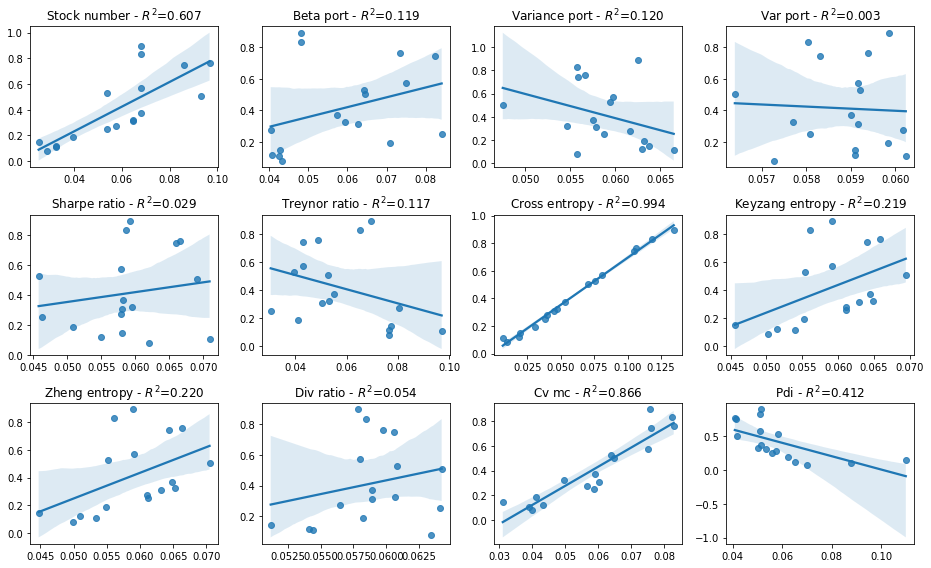

In [65]:
fig, axs = plt.subplots(3,4)
fig.set_size_inches(13,8)
axs = it.chain(*axs)


for crit, ax  in zip(dmt2.criteria, axs):
    X = dmt2.matrix[[crit]].to_numpy()
    y = result2.e_.similarity
    
    sns.regplot(x=X,y=y, ax=ax)
    reg = LinearRegression()
    reg.fit(X, y)
    y_pred = reg.predict(X)
    
    r2 = (skl_metrics.r2_score(y_true =y, y_pred= y_pred))
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    title = translate.get(crit, crit)
    title = title.replace("_", " ").capitalize()
    ax.set_title(f"{title} - $R^2$={r2:.3f}")        

    
fig.tight_layout()

In [67]:
dmt2.stats.corr()

,Stock_number,Beta_port,variance_port,VaR_port,Sharpe_Ratio,Treynor_Ratio,Cross_Entropy,KeyZang_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
Stock_number,1.000000,0.558527,-0.672192,-0.272739,0.338822,-0.502782,0.767173,0.885819,0.888656,0.486669,0.851599,-0.842302
Beta_port,0.558527,1.000000,-0.363658,-0.209126,-0.183372,-0.916066,0.345991,0.553437,0.553464,0.568888,0.469059,-0.562297
variance_port,-0.672192,-0.363658,1.000000,0.858629,-0.273016,0.422315,-0.335520,-0.646464,-0.664319,-0.762494,-0.429774,0.637982
VaR_port,-0.272739,-0.209126,0.858629,1.000000,-0.163779,0.268851,-0.044354,-0.270420,-0.291533,-0.679258,-0.086679,0.293688
Sharpe_Ratio,0.338822,-0.183372,-0.273016,-0.163779,1.000000,0.456267,0.116298,0.272567,0.275491,-0.055097,0.118811,-0.049726
Treynor_Ratio,-0.502782,-0.916066,0.422315,0.268851,0.456267,1.000000,-0.363258,-0.498443,-0.501405,-0.605832,-0.452416,0.597538
Cross_Entropy,0.767173,0.345991,-0.335520,-0.044354,0.116298,-0.363258,1.000000,0.463968,0.464941,0.235366,0.923383,-0.651751
KeyZang_Entropy,0.885819,0.553437,-0.646464,-0.270420,0.272567,-0.498443,0.463968,1.000000,0.999721,0.573096,0.608971,-0.831867
Zheng_Entropy,0.888656,0.553464,-0.664319,-0.291533,0.275491,-0.501405,0.464941,0.999721,1.000000,0.585082,0.609919,-0.834740
Div_Ratio,0.486669,0.568888,-0.762494,-0.679258,-0.055097,-0.605832,0.235366,0.573096,0.585082,1.000000,0.372574,-0.664030


In [69]:
import rankrev

In [74]:
pipe

<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('sumscaler', <SumScaler [target='matrix']>), ('critic', <Critic [correlation='pearson', scale=True]>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [75]:
rt1 = rankrev.RankReversalTest1(pipe, repeats=10, allow_missing_alternatives=True)
rt1

<RankReversalTest1 <SKCPipeline [steps=[('negateminimize', <NegateMin...> repeats=10,  allow_missing_alternatives=True last_diff_strategy=<function median at 0x7f9c880c4310> seed=None>

In [242]:
rcmp = rt1.evaluate(dmt2)
rcmp

<RanksComparator [ranks=['Original', 'M.Supervielle_1', 'M.Galicia_1', 'M.HSBC_1', 'M.MACRO_1', 'M.ICBC_1', 'M.Comafi_1', 'M.Mariva_1', 'M.Val.Bull_1', 'M.Patagonia_1', 'M.BNA_1', 'M.Bs.As._1', 'M.Credicoop_1', 'M.Val.Arpenta_1', 'M.Val.SBS_1', 'M.Val.Valiant_1', 'M.Val.Allaria_1', 'M.Supervielle_2', 'M.Galicia_2', 'M.HSBC_2', 'M.MACRO_2', 'M.ICBC_2', 'M.Comafi_2', 'M.Mariva_2', 'M.Val.Bull_2', 'M.Patagonia_2', 'M.BNA_2', 'M.Bs.As._2', 'M.Credicoop_2', 'M.Val.Arpenta_2', 'M.Val.SBS_2', 'M.Val.Valiant_2', 'M.Val.Allaria_2', 'M.Supervielle_3', 'M.Galicia_3', 'M.HSBC_3', 'M.MACRO_3', 'M.ICBC_3', 'M.Comafi_3', 'M.Mariva_3', 'M.Val.Bull_3', 'M.Patagonia_3', 'M.BNA_3', 'M.Bs.As._3', 'M.Credicoop_3', 'M.Val.Arpenta_3', 'M.Val.SBS_3', 'M.Val.Valiant_3', 'M.Val.Allaria_3', 'M.Supervielle_4', 'M.Galicia_4', 'M.HSBC_4', 'M.MACRO_4', 'M.ICBC_4', 'M.Comafi_4', 'M.Mariva_4', 'M.Val.Bull_4', 'M.Patagonia_4', 'M.BNA_4', 'M.Bs.As._4', 'M.Credicoop_4', 'M.Val.Arpenta_4', 'M.Val.SBS_4', 'M.Val.Valiant_4'

<AxesSubplot:xlabel='Method', ylabel='Alternatives'>

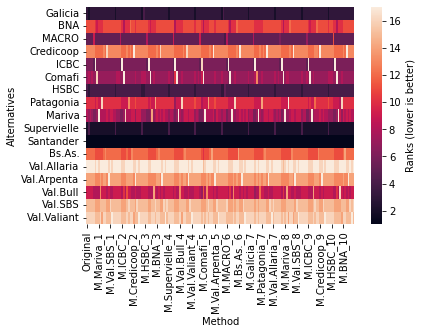

In [84]:
rcmp.plot.heatmap(annot=None)

In [227]:
rrdf = rcmp.to_dataframe().T
sort = np.argsort(rcmp.to_dataframe().T.mean()).to_numpy()
columns = rcmp.to_dataframe().T.columns
order = columns[sort]


rows = []
for r in np.arange(1, 18):
    row = {}
    for a in order:
        alt = rrdf[a].to_numpy()
        row[a] = (alt == r).sum() / len(alt)
    rows.append(row)
        
    
rrdf = pd.DataFrame(rows, index=np.arange(1,18))
rrdf.columns.name = "Stoks"
rrdf.index.name = "Ranking"

with pd.option_context('display.precision', 3):
    display(rrdf)

Stoks,Santander,Supervielle,Galicia,HSBC,MACRO,ICBC,Comafi,Mariva,Val.Bull,Patagonia,BNA,Bs.As.,Credicoop,Val.Arpenta,Val.SBS,Val.Valiant,Val.Allaria
Ranking,,,,,,,,,,,,,,,,,
1,1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.0,0.938,0.062,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.0,0.000,0.925,0.075,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.0,0.062,0.012,0.919,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.0,0.000,0.000,0.006,0.932,0.062,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.0,0.000,0.000,0.000,0.006,0.876,0.012,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.0,0.000,0.000,0.000,0.006,0.000,0.727,0.248,0.012,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.0,0.000,0.000,0.000,0.025,0.000,0.186,0.360,0.379,0.012,0.037,0.000,0.000,0.000,0.000,0.000,0.000
9,0.0,0.000,0.000,0.000,0.019,0.000,0.006,0.224,0.516,0.217,0.019,0.000,0.000,0.000,0.000,0.000,0.000


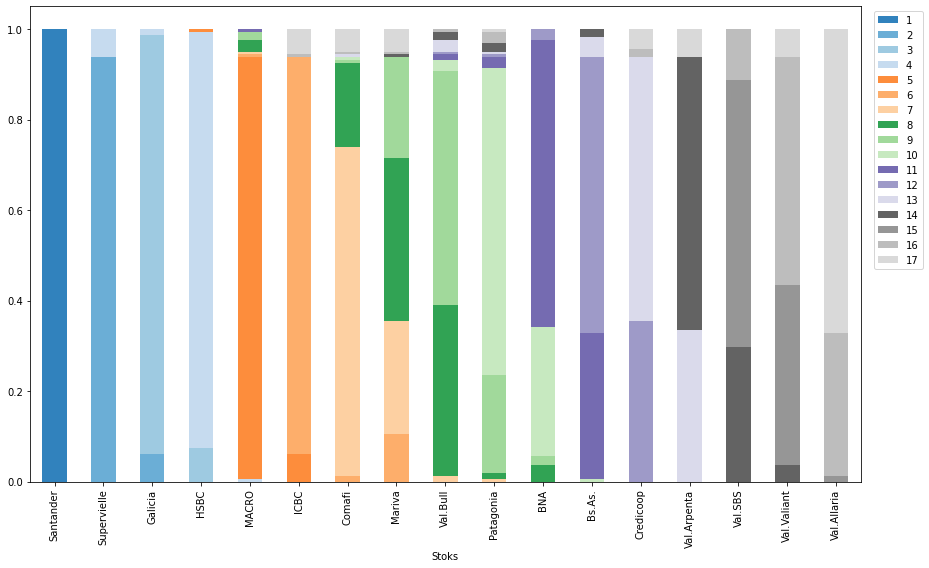

In [228]:
fig, ax = plt.subplots()
fig.set_size_inches(13,8)


rrdf.T.plot.bar(stacked=True, ax=ax, cmap="tab20c")
#sns.boxplot(data=rcmp.to_dataframe().T)

ax.legend(bbox_to_anchor=(1.01, 1.0))

fig.tight_layout()

In [238]:
(dmt2.matrix * dmt2.weights).T.describe()[

Alternatives,Santander,Supervielle,Galicia,HSBC,MACRO,ICBC,Comafi,Mariva,Val.Bull,Patagonia,BNA,Bs.As.,Credicoop,Val.Arpenta,Val.SBS,Val.Valiant,Val.Allaria
count,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000,12.00000000
mean,0.00812357,0.00746706,0.00732572,0.00707849,0.00590223,0.00572286,0.00313294,0.00538936,0.00279721,0.00419655,0.00472210,0.00436795,0.00435887,0.00388971,0.00293926,0.00256559,0.00335386
std,0.01795913,0.01574289,0.01428808,0.01400634,0.01073344,0.00958652,0.00354997,0.01000708,0.00300355,0.00555830,0.00717780,0.00614519,0.00637080,0.00517732,0.00305406,0.00248094,0.00414746
min,0.00001972,0.00001913,0.00001957,0.00001922,0.00001950,0.00001858,0.00001947,0.00001951,0.00001985,0.00001983,0.00001944,0.00001949,0.00001901,0.00001914,0.00001947,0.00001888,0.00001971
25%,0.00063330,0.00059581,0.00068566,0.00066788,0.00062867,0.00070440,0.00051169,0.00059459,0.00059198,0.00065019,0.00067454,0.00066121,0.00067326,0.00060190,0.00056412,0.00054121,0.00059840
50%,0.00200989,0.00200474,0.00214842,0.00216012,0.00248925,0.00219718,0.00167617,0.00230738,0.00191082,0.00174577,0.00231897,0.00248025,0.00239259,0.00190323,0.00173622,0.00187404,0.00203036
75%,0.00626137,0.00641886,0.00526029,0.00555921,0.00517188,0.00516119,0.00466103,0.00482735,0.00362805,0.00546396,0.00490143,0.00486028,0.00435294,0.00491512,0.00489437,0.00432532,0.00473325
max,0.06423618,0.05640031,0.05081092,0.05000368,0.03856566,0.03360049,0.00954165,0.03611494,0.00944711,0.01913739,0.02545723,0.02164081,0.02251581,0.01816073,0.00890973,0.00744130,0.01465332


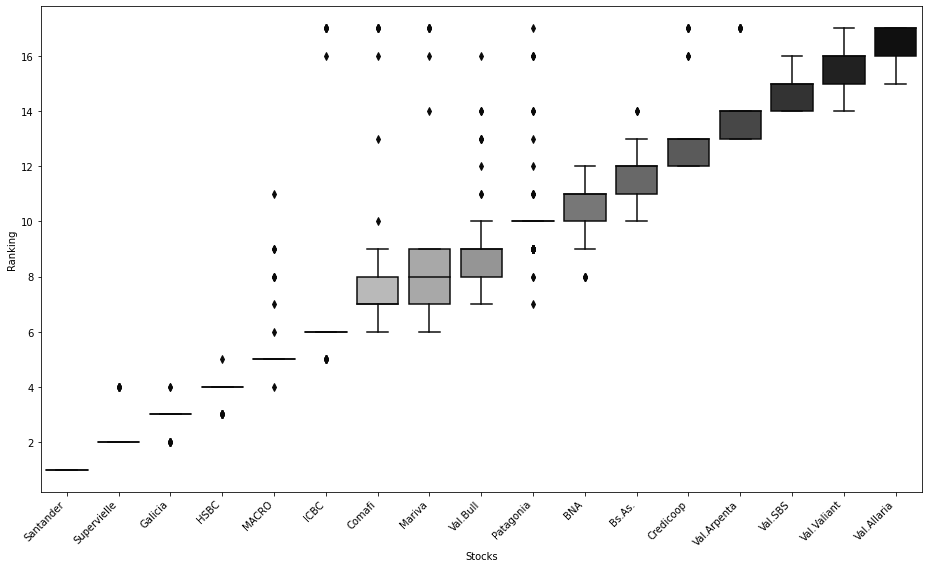

In [233]:
fig, ax = plt.subplots()
fig.set_size_inches(13,8)
sns.boxplot(data=rcmp.to_dataframe().T[order], palette="Greys")

ax.set_ylabel("Ranking")
ax.set_xlabel("Stocks")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()